In [1]:
import subprocess
import pickle
import matplotlib.pyplot as plt

In [2]:
def initialize_experiment() -> None:
    subprocess.run(["make"])

def run_experiment(strategy: str, distribution: str, cache_capacity: int, pages_number: int, queries_number: int, repetitions: int) -> float:
    result = subprocess.run(f"./experiment {strategy} {distribution} {cache_capacity} {pages_number} {queries_number} {repetitions}",
                            shell=True, capture_output=True, text=True)
    return float(result.stdout)

def clean_experiment() -> None:
    subprocess.run(["make", "clean"])

In [3]:
STRATEGIES = ["fifo", "flush-when-full", "least-frequently-used", "least-recently-used", "random", "random-markup"]
DISTRIBUTIONS = ["uniform", "geometric", "harmonic", "biharmonic"]
PAGES_NUMBER = [20, 30, 40, 50, 60, 70, 80, 90, 100]
CAPACITY_MIN_DIVIDER = 5
CAPACITY_MAX_DIVIDER = 10
QUERIES_MULTIPLIER = 1000
REPS = 100

initialize_experiment()

results = {}
for distribution in DISTRIBUTIONS:
    print(f"Running experiments for distribution: {distribution}")
    results[distribution] = {}
    for strategy in STRATEGIES:
        results[distribution][strategy] = {}
        xs = []
        ys = []
        for x in PAGES_NUMBER:
            q = x * QUERIES_MULTIPLIER
            # capacities = sorted(list(set([x // i for i in range(CAPACITY_MIN_DIVIDER, CAPACITY_MAX_DIVIDER + 1)])))
            capacities = list(range(int(x / CAPACITY_MAX_DIVIDER), int(x / CAPACITY_MIN_DIVIDER) + 1))
            for c in capacities:
                xs.append((x, c))
                ys.append(run_experiment(strategy, distribution, c, x, q, REPS))
        results[distribution][strategy]["xs"] = xs
        results[distribution][strategy]["ys"] = ys

with open("results.pkl", "wb") as f:
    pickle.dump(results, f)
        
clean_experiment()

g++ -std=c++17 -Wall -Wextra -Werror -pedantic -O3 main.cpp -o experiment
Running experiments for distribution: uniform
Running experiments for distribution: geometric
Running experiments for distribution: harmonic
Running experiments for distribution: biharmonic
rm -f experiment


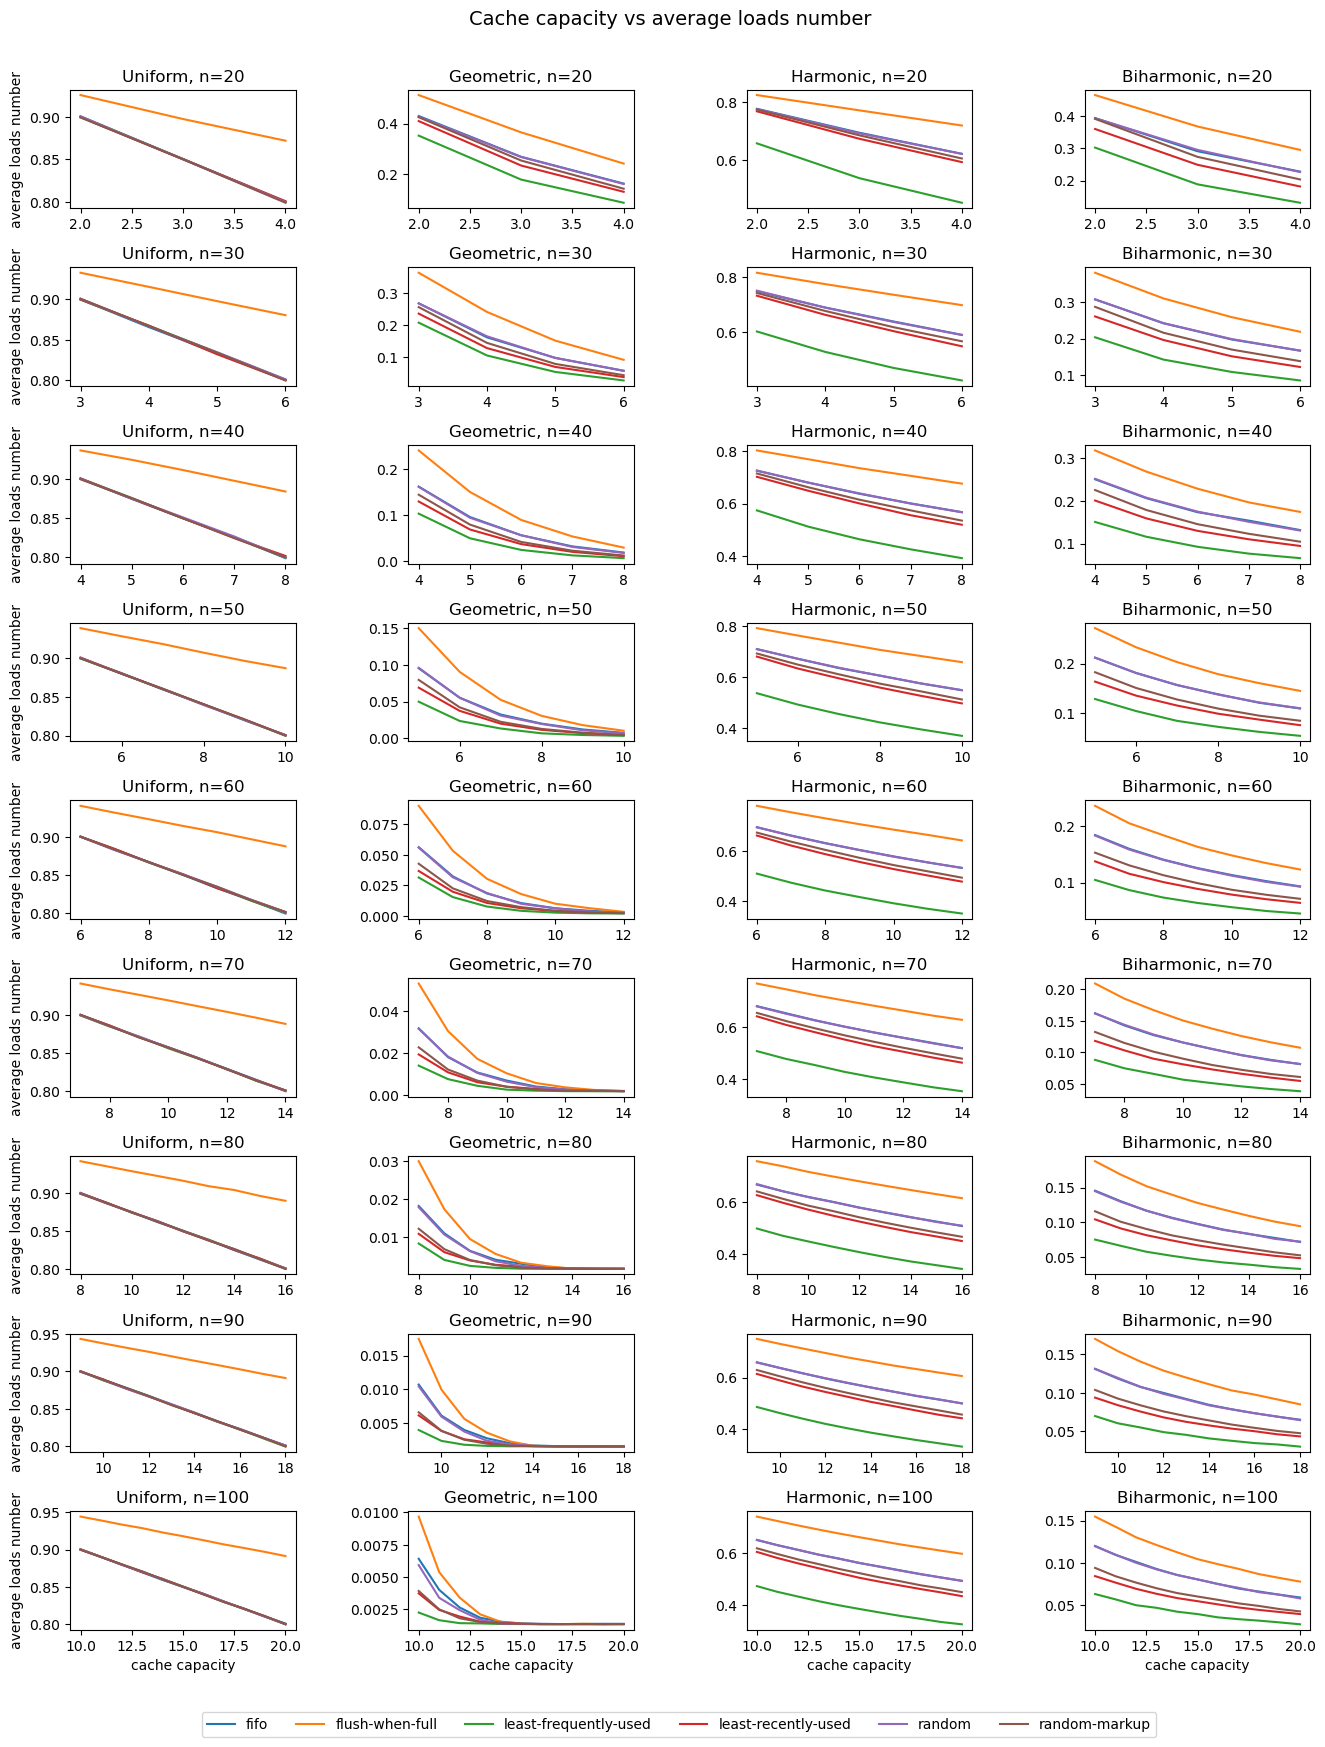

In [7]:
MERGE_VIEW = True

with open("results.pkl", "rb") as f:
    results = pickle.load(f)

data = {}
for distribution in DISTRIBUTIONS:
    data[distribution] = {}
    for strategy in STRATEGIES:
        xs = results[distribution][strategy]["xs"]
        ys = results[distribution][strategy]["ys"]
        values = {}
        for x, y in zip(xs, ys):
            x_n = x[0]
            x_c = x[1]
            if x_n not in values:
                values[x_n] = []
            values[x_n].append((x_c, y))
        data[distribution][strategy] = values

if MERGE_VIEW:
    fig, axs = plt.subplots(len(PAGES_NUMBER), len(DISTRIBUTIONS), figsize=(16, 20))
    plt.subplots_adjust(wspace=0.5, hspace=0.5) 
    for di, distribution in enumerate(DISTRIBUTIONS):
        for pni, pn in enumerate(PAGES_NUMBER):
            for strategy in STRATEGIES:
                if pn in data[distribution][strategy]:
                    xs = [x[0] for x in data[distribution][strategy][pn]]
                    ys = [x[1] for x in data[distribution][strategy][pn]]
                    axs[pni, di].plot(xs, ys, label=strategy)
                    axs[pni, di].set_title(f"{distribution.capitalize()}, n={pn}")
                    if di == 0:
                        axs[pni, di].set_ylabel("average loads number") 
                    if pni == len(PAGES_NUMBER) - 1:
                        axs[pni, di].set_xlabel("cache capacity")
    plt.suptitle("Cache capacity vs average loads number", fontsize=14, y=0.92)          
    plt.legend(loc='center', bbox_to_anchor=(-1.8, -0.8), ncol=6)
    plt.show()
    # plt.savefig(f"plots/distribution.png")
    plt.close()
else:
    for distribution in DISTRIBUTIONS:
        for pn in PAGES_NUMBER:
            plt.figure()
            for strategy in STRATEGIES:
                if pn in data[distribution][strategy]:
                    xs = [x[0] for x in data[distribution][strategy][pn]]
                    ys = [x[1] for x in data[distribution][strategy][pn]]
                    plt.plot(xs, ys, label=strategy)
            plt.title(f"Distribution: {distribution}, Pages number: {pn}")
            plt.xlabel("Cache capacity")
            plt.ylabel("Average loads number")
            plt.legend()
            plt.show()
            # plt.savefig(f"plots/{distribution}_{pn}.png")
            plt.close()

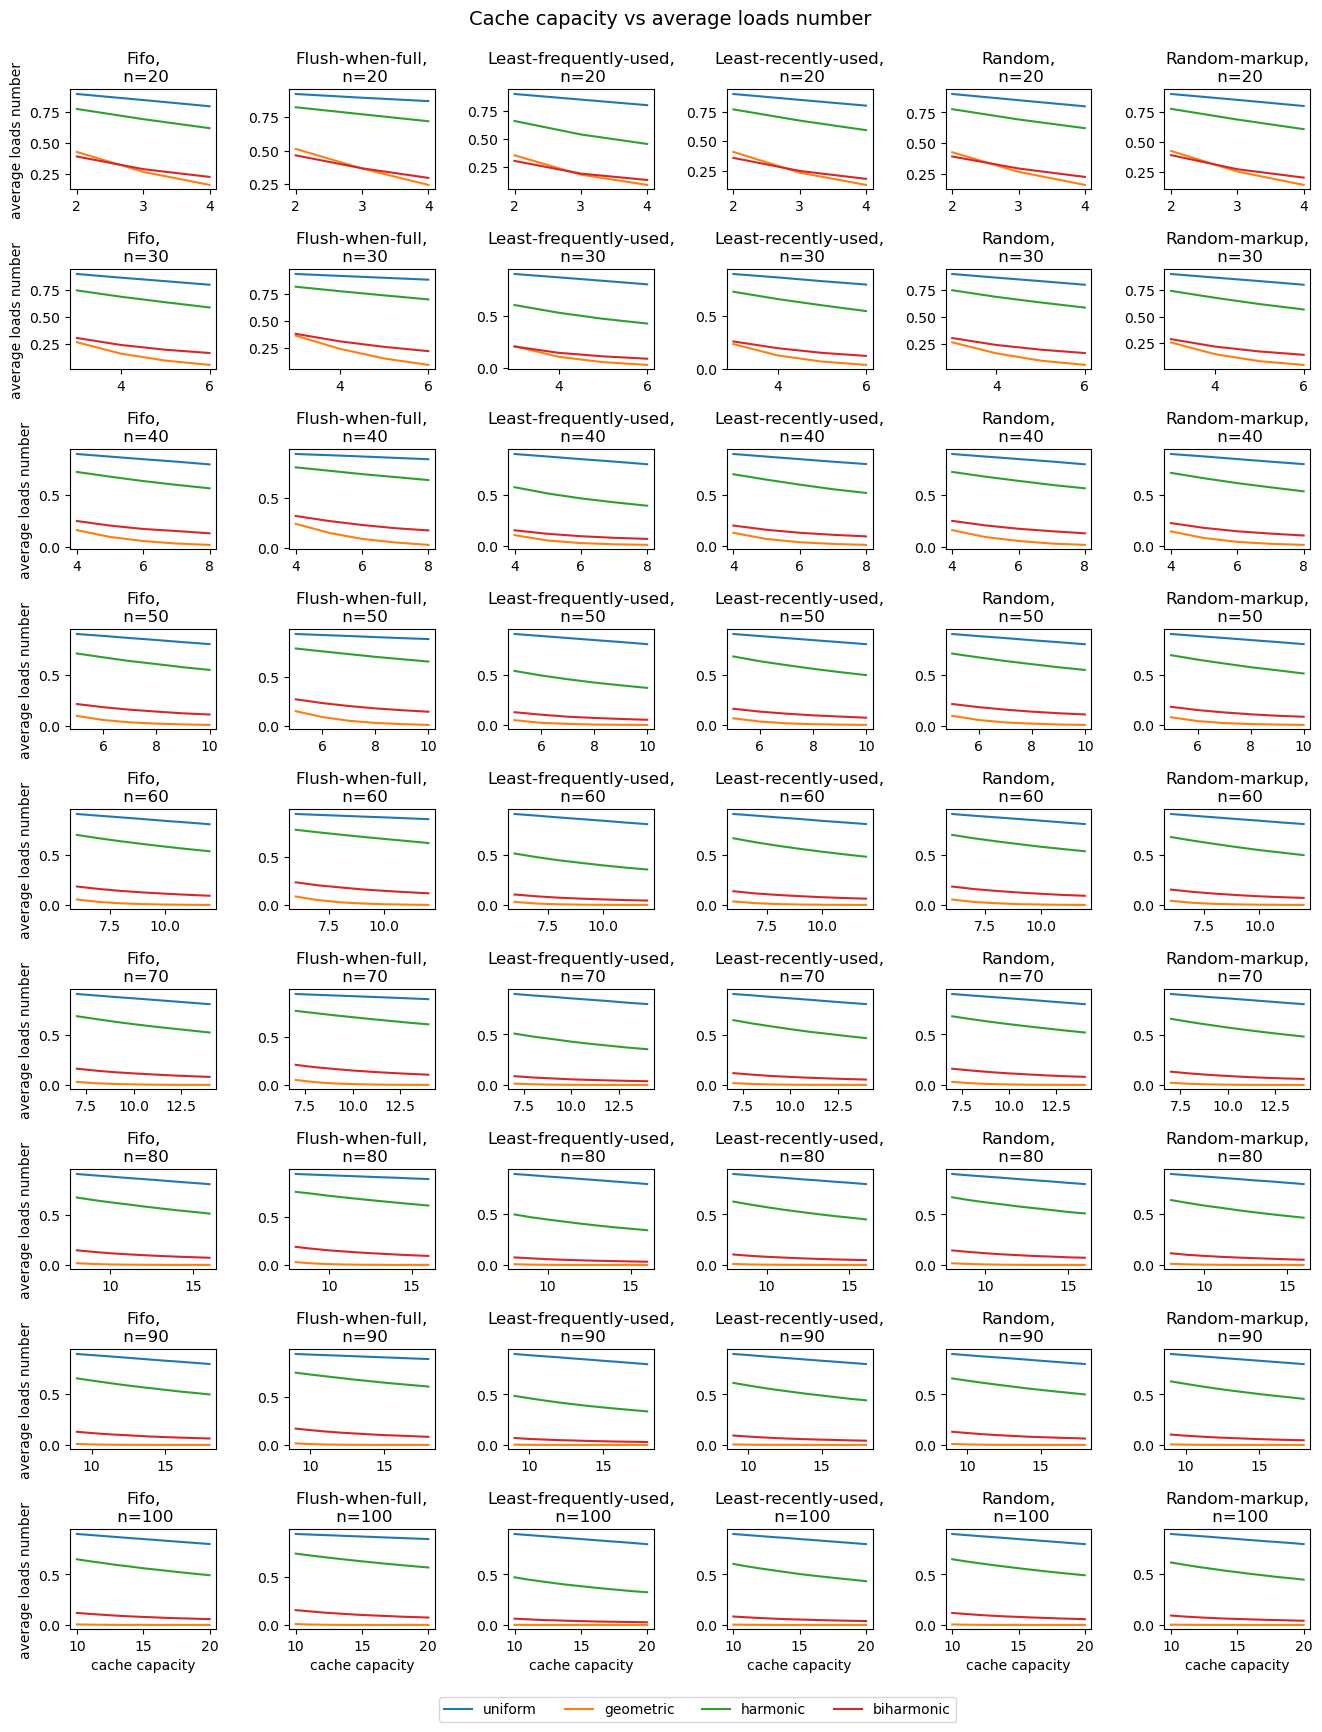

In [6]:
MERGE_VIEW = True

with open("results.pkl", "rb") as f:
    results = pickle.load(f)

data = {}
for distribution in DISTRIBUTIONS:
    for strategy in STRATEGIES:
        if strategy not in data:
            data[strategy] = {}
        if distribution not in data[strategy]:
            data[strategy][distribution] = {}

        xs = results[distribution][strategy]["xs"]
        ys = results[distribution][strategy]["ys"]
        values = {}
        for x, y in zip(xs, ys):
            x_n = x[0]
            x_c = x[1]
            if x_n not in values:
                values[x_n] = []
            values[x_n].append((x_c, y))
        data[strategy][distribution] = values

if MERGE_VIEW:
    fig, axs = plt.subplots(len(PAGES_NUMBER), len(STRATEGIES), figsize=(16, 20))
    plt.subplots_adjust(wspace=0.5, hspace=0.8) 
    for si, strategy in enumerate(STRATEGIES):
        for pni, pn in enumerate(PAGES_NUMBER):
            for distribution in DISTRIBUTIONS:
                if pn in data[strategy][distribution]:
                    xs = [x[0] for x in data[strategy][distribution][pn]]
                    ys = [x[1] for x in data[strategy][distribution][pn]]
                    axs[pni, si].plot(xs, ys, label=distribution)
                    axs[pni, si].set_title(f"{strategy.capitalize()},\n n={pn}")
                    if si == 0:
                        axs[pni, si].set_ylabel("average loads number") 
                    if pni == len(PAGES_NUMBER) - 1:
                        axs[pni, si].set_xlabel("cache capacity")

    plt.suptitle("Cache capacity vs average loads number", fontsize=14, y=0.92)          
    plt.legend(loc='center', bbox_to_anchor=(-3.2, -0.8), ncol=6)
    plt.show()
    # plt.savefig(f"plots/strategy.png")
    plt.close()
else:
    for strategy in STRATEGIES:
        for pn in PAGES_NUMBER:
            plt.figure()
            for distribution in DISTRIBUTIONS:
                if pn in data[strategy][distribution]:
                    xs = [x[0] for x in data[strategy][distribution][pn]]
                    ys = [x[1] for x in data[strategy][distribution][pn]]
                    plt.plot(xs, ys, label=distribution)
            plt.title(f"Strategy: {strategy}, Pages number: {pn}")
            plt.xlabel("Cache capacity")
            plt.ylabel("Average loads number")
            plt.legend()
            plt.show()
            # plt.savefig(f"plots/{strategy}_{pn}.png")
            plt.close()